In [1]:
%pylab inline
import random

import numpy as np
import random
import pickle
from tqdm import tqdm
import letor_metrics

Populating the interactive namespace from numpy and matplotlib


In [2]:
# raw_data = np.loadtxt('./data/ml-1m/ratings.dat', delimiter='::')

In [3]:
# from dataset import TripletsDataset

In [4]:
# ds = TripletsDataset(raw_data, threshold_user=60, rnd_seed=42)
# ds.train_test_split(n_train=50)

In [5]:
# pickle.dump(ds, open('./tmp/ds_rank.pkl', 'wb'))
ds = pickle.load(open('./tmp/ds.pkl', 'rb'))

In [6]:
ds.init_cached_random()

# define model

In [7]:
import tensorflow as tf
import ranknn
import imp

import tensorflow.contrib.slim as slim

In [46]:
imp.reload(ranknn)

<module 'ranknn' from '/Users/mikhail/std/repos/nnmf/ranknn.py'>

In [47]:
model.destroy()

AttributeError: 'RANK_NN' object has no attribute 'session'

In [48]:
N_USERS = 6041 #int(max(raw_data[:, 0])) + 1
N_ITEMS = 3953 #int(max(raw_data[:, 1])) + 1
N_EMBEDDINGS = 20

In [49]:
def inner_network(user_emb, item_emb_left, item_emb_right):
    joined_input = tf.concat(1, [user_emb, item_emb_left, item_emb_right])
    net = slim.fully_connected(inputs=joined_input, num_outputs=64, activation_fn=tf.nn.relu)
#     net = slim.fully_connected(inputs=net, num_outputs=128, activation_fn=tf.nn.relu)
#     net = slim.fully_connected(inputs=net, num_outputs=32, activation_fn=tf.nn.relu)
    net = slim.fully_connected(inputs=net, num_outputs=1, activation_fn=None)
    return net

In [50]:
model = ranknn.RANK_NN(N_USERS, N_ITEMS, N_EMBEDDINGS, alpha=0., beta=0.9, alpha_reg=0.0, inner_net=inner_network)
model.build_graph()
model.initialize_session()

In [51]:
model.sw.add_graph(model.graph)

In [52]:
model.saver.save(model.session, save_path='./tmp/')

'./tmp/'

In [47]:
losses = []
batch_size = 1024
for n_batches, cur_optim in [(5000, model.trainer_2)]:
    for i in tqdm(range(n_batches)):
        batch = ds.sample_train_batch(n_samples=batch_size)
        fd = {
            model.user_ids:  batch['users'], 
            model.left_ids:  batch['left_items'],
            model.right_ids: batch['right_items'],
            model.target_y:  batch['y'],
        }
        el, nl, reg, t, m, _ = model.session.run(
            [model.embedding_loss, model.net_loss, model.regularization, model.target, model.net_margins, cur_optim], 
            feed_dict=fd
        )
        hitrate = np.mean((m>0) * (batch['y']>0))
        losses.append((el, nl, reg, t, hitrate))
        if i%500==0:
            user_norm = np.linalg.norm(model.weights_u)
            item_norm = np.linalg.norm(model.weights_i)
            print('[it {}] weight norms, users: {}, items: {}'.format(i, user_norm, item_norm))
            print('[it {}] metrics (emb_loss, net_loss, reg, target, hr): {}'.format(i, losses[-1]))

  0%|          | 6/5000 [00:00<06:30, 12.79it/s]

[it 0] weight norms, users: 161.9365234375, items: 200.6286163330078
[it 0] metrics (emb_loss, net_loss, reg, target, hr): (0.81547177, 0.71982825, 19.949562, 0.64784539, 0.5)


 10%|█         | 508/5000 [00:08<01:12, 62.16it/s]

[it 500] weight norms, users: 176.4070587158203, items: 231.11866760253906
[it 500] metrics (emb_loss, net_loss, reg, target, hr): (1.4171125, 0.48707008, 25.232042, 0.43836308, 0.376953125)


 20%|██        | 1012/5000 [00:16<01:04, 61.84it/s]

[it 1000] weight norms, users: 187.50326538085938, items: 247.4552001953125
[it 1000] metrics (emb_loss, net_loss, reg, target, hr): (1.7082754, 0.47480917, 29.7292, 0.42732823, 0.3681640625)


 30%|███       | 1510/5000 [00:25<00:57, 60.86it/s]

[it 1500] weight norms, users: 199.8705291748047, items: 266.2725830078125
[it 1500] metrics (emb_loss, net_loss, reg, target, hr): (1.8991516, 0.38454351, 35.124268, 0.34608915, 0.408203125)


 40%|████      | 2012/5000 [00:33<00:48, 61.50it/s]

[it 2000] weight norms, users: 210.58267211914062, items: 281.403564453125
[it 2000] metrics (emb_loss, net_loss, reg, target, hr): (2.1259196, 0.36148661, 39.360611, 0.32533795, 0.427734375)


 50%|█████     | 2507/5000 [00:41<00:42, 58.50it/s]

[it 2500] weight norms, users: 219.90155029296875, items: 292.8920593261719
[it 2500] metrics (emb_loss, net_loss, reg, target, hr): (2.3547029, 0.35616162, 43.626434, 0.32054546, 0.4130859375)


 60%|██████    | 3007/5000 [00:50<00:32, 60.82it/s]

[it 3000] weight norms, users: 228.30555725097656, items: 303.1051330566406
[it 3000] metrics (emb_loss, net_loss, reg, target, hr): (2.3298965, 0.33658263, 46.884178, 0.30292436, 0.41796875)


 70%|███████   | 3507/5000 [00:59<00:25, 57.89it/s]

[it 3500] weight norms, users: 236.3151092529297, items: 312.4385681152344
[it 3500] metrics (emb_loss, net_loss, reg, target, hr): (2.5653625, 0.32010609, 50.155518, 0.28809547, 0.4248046875)


 80%|████████  | 4010/5000 [01:08<00:17, 55.02it/s]

[it 4000] weight norms, users: 243.85191345214844, items: 321.36712646484375
[it 4000] metrics (emb_loss, net_loss, reg, target, hr): (2.9051008, 0.31669402, 54.052185, 0.28502461, 0.43359375)


 90%|█████████ | 4513/5000 [01:16<00:08, 59.37it/s]

[it 4500] weight norms, users: 251.46896362304688, items: 329.9829406738281
[it 4500] metrics (emb_loss, net_loss, reg, target, hr): (2.9323463, 0.30266497, 57.977211, 0.27239847, 0.4365234375)


100%|██████████| 5000/5000 [01:25<00:00, 58.41it/s]


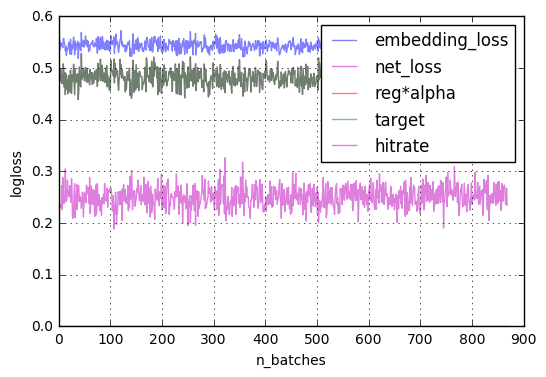

In [26]:
plot([x[0] for x in losses], c='b', label='embedding_loss', alpha=0.5)
plot([x[1] for x in losses], c='m', label='net_loss', alpha=0.5)
plot([x[2]*model.alpha_reg for x in losses], c='r', label='reg*alpha', alpha=0.5)
plot([x[3] for x in losses], c='g', label='target', alpha=0.5)
plot([x[4] for x in losses], c='m', label='hitrate', alpha=0.5)
grid()
legend()
xlabel('n_batches')
ylabel('logloss')

In [15]:
def compare_triple(model, u, i, j):
    fd = {
        model.user_ids:   np.array([u]).astype(np.int32), 
        model.left_ids:   np.array([i]).astype(np.int32),
        model.right_ids:  np.array([j]).astype(np.int32)
    }
    net_margin, embed_margin = model.session.run([model.net_margins, model.embedding_margins], feed_dict=fd)
    return net_margin[0]
    

In [18]:
def sort_user(model, user_list, user_id, k=10):
    te = [i for i, r in user_list]
    res = []
    if compare_triple(model, user_id, te[0], te[1]) > 0:
        res = [0, 1]
    else:
        res = [1, 0]

    for j, new in enumerate(te[2:]):
        for i, base in enumerate(res[:k]):
            if compare_triple(model, user_id, new, base) > 0:
                res.insert(i, j)
                break
            res.append(j)
        res = res[:k]
#     print(res)
    return [user_list[i][1] for i in res]

In [19]:
u = ds.data_keys[4]
sort_user(model, ds.test[u], u, 10)

[3, 2, 2, 2, 3, 3, 3, 3, 3, 3]

In [20]:
imp.reload(letor_metrics)

<module 'letor_metrics' from '/Users/mikhail/std/repos/nnmf/letor_metrics.py'>

In [21]:
ndcg_vals = []
ndcg_hist =[]
for u in tqdm(ds.data_keys[:100], desc='Prediction', leave=True):
    predicted_relevances = sort_user(model, ds.test[u], u, k=10)
    ndcg_hist.append(predicted_relevances)
    gain = letor_metrics.ndcg_score_from_raw(np.array([v for k,v in ds.test[u][:10]]), 
                                             np.array(predicted_relevances))
    ndcg_vals.append(gain)

Prediction: 100%|██████████| 100/100 [00:19<00:00,  2.32it/s]


In [22]:
np.mean(ndcg_vals)

0.29608622721670358

In [60]:
ndcg_vals

[0.4292000334710187,
 0.14771294781349395,
 0.48863939286386843,
 0.46705114533134479,
 0.281847256772355,
 0.30411568871496136,
 0.1754515310687248,
 0.25523730621128138,
 0.20970509785852331,
 0.1530595538464225,
 0.26217806148602074,
 0.06910710909459572,
 0.10511454143322035,
 0.046130201889997537,
 0.26509652738128958,
 0.31555438436321354,
 0.062516135052946759,
 0.44800784266839122,
 0.17090214494776762,
 0.27540520449437417,
 0.16996483752305172,
 0.049849687463837299,
 0.2380881581756682,
 0.12454585702413341,
 0.27417934563060076,
 0.27577615499016056,
 0.7691124763354289,
 0.16952109131486781,
 0.1530595538464225,
 0.19143863401067854,
 0.036532530545444454,
 0.087815326201706165,
 0.17618144872080505,
 0.26197421724018521,
 0.13510969885036322,
 0.63107057111225029,
 0.75173328794341721,
 0.2168475842662223,
 0.072023667553653137,
 0.24279167047743566,
 0.12517313113523615,
 0.14420026539304082,
 0.35528489523340806,
 0.74520648869111894,
 0.50104171439064304,
 0.6497861001

In [84]:
ndcg_hist[0]

[3, 3, 3, 2, 2, 3, 3, 3, 2, 2]

In [85]:
ds.test[ds.data_keys[0]]

[(3468, 5),
 (3578, 5),
 (1610, 5),
 (1259, 5),
 (3147, 5),
 (110, 5),
 (1945, 5),
 (515, 5),
 (480, 5),
 (1370, 5),
 (1193, 5),
 (590, 5),
 (1196, 5),
 (593, 5),
 (1124, 5),
 (1957, 5),
 (380, 5),
 (920, 5),
 (318, 5),
 (356, 5),
 (3068, 4),
 (1537, 4),
 (648, 4),
 (3035, 4),
 (1544, 4),
 (1188, 4),
 (3255, 4),
 (982, 4),
 (1873, 4),
 (2858, 4),
 (265, 4),
 (1442, 4),
 (2353, 4),
 (736, 4),
 (2571, 4),
 (2396, 4),
 (1955, 4),
 (349, 4),
 (1096, 4),
 (1527, 4),
 (3418, 4),
 (2628, 3),
 (1103, 3),
 (2916, 3),
 (2881, 3),
 (1217, 3),
 (2126, 3),
 (3108, 3),
 (3257, 3),
 (2278, 3),
 (2490, 3),
 (1690, 3),
 (3654, 3),
 (442, 3),
 (1408, 3),
 (1084, 3),
 (1265, 3),
 (1801, 3),
 (2359, 3),
 (2717, 3),
 (3735, 3),
 (1597, 3),
 (3809, 3),
 (165, 3),
 (2321, 3),
 (459, 3),
 (1385, 3),
 (498, 3),
 (3678, 3),
 (1213, 2),
 (3107, 2),
 (902, 2),
 (3256, 2),
 (3699, 2),
 (2427, 2),
 (95, 2),
 (1090, 2),
 (21, 1),
 (3893, 1)]